In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

<h1><center>Data loading and management </center></h1>

In [2]:
RS = 50

In [3]:
df = pd.read_csv('data.csv', index_col = 0)

In [4]:
df.y = df.y.replace(5,0)
df.y = df.y.replace(4,0)
df.y = df.y.replace(3,0)
df.y = df.y.replace(2,0)

In [5]:
y = df['y']
y = y.to_frame()
y = y.reset_index(drop=True)

In [6]:
matrix = pd.read_csv('matrix.csv', header = None)
matrixY = pd.concat([matrix, y], axis = 1)
matrix.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'median', 'std', 'sampen']
matrixY.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'median', 'std', 'sampen', 'y']

In [7]:
#Following class recommendations here
matrix = matrix.dropna()
matrixY = matrixY.dropna()

In [8]:
matrixY

,delta,theta,alpha,beta,gamma,median,std,sampen,y
0,0.364844,0.559161,0.079584,0.026149,0.000880,5.410112,95.980947,1.300240,0
1,0.717625,0.263611,0.072320,0.018437,0.000310,192.387640,473.166815,0.255622,1
2,0.498219,0.413281,0.097799,0.040984,0.001313,-0.455056,44.311025,1.264674,0
3,0.434451,0.412057,0.145145,0.079406,0.006416,-0.089888,15.968642,1.307791,0
4,0.414346,0.247997,0.279504,0.082593,0.001914,5.651685,38.802149,1.487650,0
...,...,...,...,...,...,...,...,...,...
11495,0.871073,0.182500,0.010571,0.010560,0.001119,2.342697,38.376487,0.821097,0
11496,0.723748,0.378775,0.020603,0.006286,0.000480,21.825843,163.538573,0.400909,1
11497,0.586311,0.200244,0.121118,0.109889,0.005512,1.747191,44.289439,1.607124,0
11498,0.779361,0.215305,0.028136,0.016949,0.001576,-1.157303,63.607269,0.730210,0


In [9]:
print(matrixY.groupby('y').mean())

      delta     theta     alpha      beta     gamma     median         std  \
y                                                                            
0  0.621197  0.303236  0.070128  0.033694  0.002122  -0.590223   51.534849   
1  0.618228  0.307837  0.092345  0.022454  0.000951  10.516119  303.472484   

     sampen  
y            
0  1.007996  
1  0.521035  


In [10]:
print(matrixY.groupby('y').std())

      delta     theta     alpha      beta     gamma     median         std  \
y                                                                            
0  0.252686  0.212799  0.065848  0.037655  0.002264  10.996807   34.239186   
1  0.179411  0.133832  0.095465  0.020611  0.001234  81.414896  153.077731   

     sampen  
y            
0  0.335720  
1  0.198588  


In [11]:
#grr = pd.plotting.scatter_matrix(matrixY, hist_kwds={'bins':20},s=60, alpha=0.8)

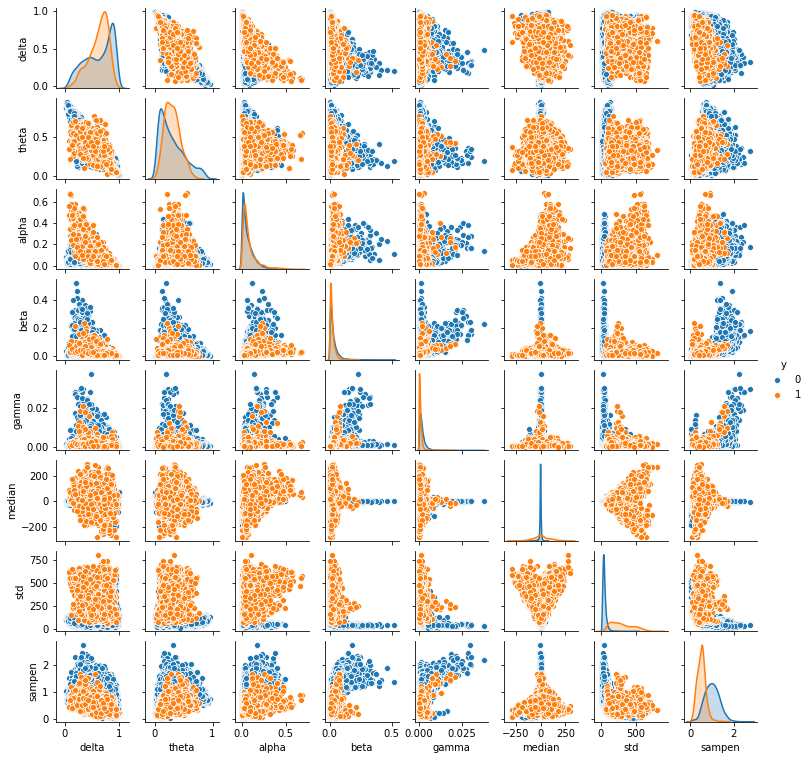

In [12]:
sns.pairplot(matrixY, diag_kind = "kde", hue = 'y', height = 1.3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(matrix, y, test_size = 0.20, random_state = RS)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)

In [15]:
scaler2 = StandardScaler()
scaler2.fit(matrix)
matrixS = scaler2.transform(matrix)

In [16]:
matrixS = pd.DataFrame(matrixS)
matrixS.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'median', 'std', 'sampen']
X_trainS = pd.DataFrame(X_trainS)
X_trainS.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'median', 'std', 'sampen']
X_testS = pd.DataFrame(X_testS)
X_testS.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'median', 'std', 'sampen']

In [17]:
#Select best features

SKB = SelectKBest(k=7).fit(matrix, y.values.ravel())
matrixN = SKB.transform(matrix)

X_trainN, X_testN, y_train, y_test = train_test_split(matrixN, y, test_size = 0.20, random_state = RS)

scaler3 = StandardScaler()
scaler3.fit(X_trainN)
X_trainN = scaler3.transform(X_trainN)
X_testN = scaler3.transform(X_testN)
matrixN = scaler3.transform(matrixN)

#print(matrixN)
print('Best features after matlab norm: std, sampen, gamma, beta, alpha, median, theta, delta \n')

Best features after matlab norm: std, sampen, gamma, beta, alpha, median, theta, delta 



<h1><center>KNN classification </center></h1>

In [18]:
#current model input - best is N @ 7
QQQ = X_trainN
QQQ2 = X_testN
QQQ3 = matrixN

In [19]:
#TRAIN TEST SPLIT

k_values = np.arange(1,100,1)
k_test_output = []
for Q in k_values:
    KNNclassifier = KNeighborsClassifier(n_neighbors=Q, n_jobs = -1, weights = 'distance', p = 1)
    KNNclassifier.fit(QQQ, y_train.values.ravel())
    z = KNNclassifier.score(QQQ2, y_test)
    k_test_output.append(z)

Text(0, 0.5, 'Accuracy')

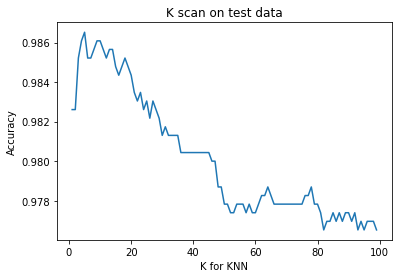

In [20]:
plt.plot(k_values, k_test_output)
plt.title('K scan on test data')
plt.xlabel('K for KNN')
plt.ylabel('Accuracy')

In [21]:
ideal_k = k_test_output.index(max(k_test_output))+1
print(ideal_k)

5


In [22]:
KNNclassifier = KNeighborsClassifier(n_neighbors=ideal_k, weights = 'distance', p = 1)
KNNclassifier.fit(QQQ, y_train.values.ravel())
y_predKNN = KNNclassifier.predict(QQQ2)

In [23]:
print('KNN confusion matrix: \n')
print(confusion_matrix(y_test, y_predKNN), '\n')
print('KNN classification report: \n')
print(classification_report(y_test, y_predKNN))

KNN confusion matrix: 

[[1853   16]
 [  15  416]] 

KNN classification report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1869
           1       0.96      0.97      0.96       431

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300



In [24]:
#Cross validation

kfold = 10
knnscores = cross_validate(KNNclassifier, QQQ3, y.values.ravel(), cv = kfold, scoring = 'f1')
#print('\n', knnscores['test_score'])
#print('\n')
print('Mean score over', kfold, 'fold-CV:', knnscores['test_score'].mean(), '\n')

Mean score over 10 fold-CV: 0.9561064546600047 



In [25]:
knnf1 = knnscores['test_score'].mean()
print(knnf1)

0.9561064546600047


In [26]:
knnf1S = knnscores['test_score'].std()
print(knnf1S)

0.005912289616165843


<h1><center>Logistic regression </center></h1>

In [27]:
#Testing different predictor combinations

#matrixM = matrixS[["std", "sampen"]]
#X_trainM = X_trainS[["std", "sampen"]]
#X_testM = X_testS[["std", "sampen"]]


matrixM = matrix[["gamma", "beta", "alpha", "median", "theta", "delta"]]
X_trainM = X_train[["gamma", "beta", "alpha", "median", "theta", "delta"]]
X_testM = X_test[["gamma", "beta", "alpha", "median", "theta", "delta"]]

In [28]:
EEE = X_trainS
EEE2 = X_testS
EEE3 = matrixS

In [29]:
logreg = LogisticRegression(C = 2, fit_intercept = False, max_iter = 500, class_weight = 'balanced')
logreg.fit(EEE, y_train.values.ravel())
y_predLR = logreg.predict(EEE2)
print('Score =', logreg.score(EEE2, y_test),'\n')

Score = 0.9634782608695652 



In [30]:
print('Logistic regression confusion matrix: \n')
print(confusion_matrix(y_test, y_predLR), '\n')
print('Logistic regression classification report: \n')
print(classification_report(y_test, y_predLR))

Logistic regression confusion matrix: 

[[1800   69]
 [  15  416]] 

Logistic regression classification report: 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1869
           1       0.86      0.97      0.91       431

    accuracy                           0.96      2300
   macro avg       0.92      0.96      0.94      2300
weighted avg       0.97      0.96      0.96      2300



In [31]:
#Cross validation

lrscores = cross_validate(logreg, EEE3, y.values.ravel(), cv = kfold, scoring = 'f1')

print('Mean score over', kfold, 'fold-CV:', lrscores['test_score'].mean())
print('Best ever: 0.902014632367018 with matrixS')

Mean score over 10 fold-CV: 0.9100394252708008
Best ever: 0.902014632367018 with matrixS


In [32]:
lrf1 = lrscores['test_score'].mean()
print(lrf1)

0.9100394252708008


In [33]:
lrf1S = lrscores['test_score'].std()
print(lrf1S)

0.008603931686984019


<h1><center>Artificial neural network </center></h1>

In [34]:
YYY = X_trainS
YYY2 = X_testS
YYY3 = matrixS

In [35]:
#hidden layer size determined by CV below

mlp = MLPClassifier(hidden_layer_sizes = (4, 3), alpha=1e-4, max_iter=1500)
mlp.fit(YYY, y_train.values.ravel())
#MLPprob = mlp.predict_proba(YYY2)
y_predMLP = mlp.predict(YYY2)
#print('Predicted probability of the first 5 test examples:\n', y_predMLP[0:5], '\n')
#print('Score = ', mlp.score(YYY2, y_test), '\n')

CROSS VALIDATION TO FIND OPTIMUM HIDDEN LAYER SIZES

layers = [x for x in range (1,8)]
cv_scores = []
for l in layers:
    mlp2 = MLPClassifier(hidden_layer_sizes = (4, 3), alpha = 1e-4, max_iter=800)
    scores = cross_val_score(mlp2, YYY, y_train.values.ravel(), cv=5, scoring='f1')
    cv_scores.append(scores.mean())

layers = [x for x in range (1,6)]
layers2 = [x for x in range (1,4)]
cv_scores = []
for l in layers:
    for k in layers2:
        mlp2 = MLPClassifier(hidden_layer_sizes = (l, k), alpha = 1e-4, max_iter=800)
        scores = cross_val_score(mlp2, YYY, y_train.values.ravel(), cv=5, scoring='f1')
        cv_scores.append(scores.mean())

annmaxindex = cv_scores.index(max(cv_scores))
print(annmaxindex)
print(cv_scores[annmaxindex])


In [36]:
print('ANN confusion matrix: \n')
print(confusion_matrix(y_test, y_predMLP), '\n')
print('ANN classification report: \n')
print(classification_report(y_test, y_predMLP))

ANN confusion matrix: 

[[1852   17]
 [  22  409]] 

ANN classification report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1869
           1       0.96      0.95      0.95       431

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



In [37]:
#Cross validation

mlpscores = cross_validate(mlp, YYY3, y.values.ravel(), cv = kfold, scoring = 'f1')

print('Mean score over', kfold, 'fold-CV:', mlpscores['test_score'].mean())
print('Best score: 0.9528428412402834')

Mean score over 10 fold-CV: 0.9515910637118792
Best score: 0.9528428412402834


In [38]:
mlpf1 = mlpscores['test_score'].mean()
print(mlpf1)

0.9515910637118792


In [39]:
mlpf1S = mlpscores['test_score'].std()
print(mlpf1S)

0.012495956375550659


<h1><center>Support vector machine </center></h1>

In [40]:
UUU = X_trainS
UUU2 = X_testS
UUU3 = matrixS

In [41]:
clf = SVC(kernel = 'rbf', C=3)
clf.fit(UUU, y_train.values.ravel())
y_predSVC = clf.predict(UUU2)
print('Training accuracy = ', clf.score(UUU,y_train),'\n')

Training accuracy =  0.9857608695652174 



In [42]:
print('SVC confusion matrix: \n')
print(confusion_matrix(y_test, y_predSVC), '\n')
print('SVC classification report: \n')
print(classification_report(y_test, y_predSVC))

SVC confusion matrix: 

[[1853   16]
 [  15  416]] 

SVC classification report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1869
           1       0.96      0.97      0.96       431

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300



In [43]:
#Cross validation

svcscores = cross_validate(clf, UUU3, y.values.ravel(), cv = kfold, scoring = 'f1')

print('Mean score over', kfold, 'fold-CV:', svcscores['test_score'].mean())
print('Best score: 0.963456177284329')

Mean score over 10 fold-CV: 0.9627562303504152
Best score: 0.963456177284329


In [44]:
svcf1 = svcscores['test_score'].mean()
print(svcf1)

0.9627562303504152


In [45]:
svcf1S = svcscores['test_score'].std()
print(svcf1S)

0.007272206396180836


<h1><center>Principal component analysis </center></h1>

In [46]:
pca = PCA(n_components=2)
pca.fit(matrixS)
matrix_PCA = pca.transform(matrixS)
matrix_PCA = pd.DataFrame(matrix_PCA)

In [47]:
print('\nVariance explained:', pca.explained_variance_ratio_)
print('\nCumulative variance explained:', np.cumsum(pca.explained_variance_ratio_))


Variance explained: [0.38310387 0.2251534 ]

Cumulative variance explained: [0.38310387 0.60825727]


  -------------------Trying logistic regression with PCA dataset-------------------  

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(matrix_PCA, y, test_size = 0.20, random_state = RS)

In [49]:
logreg2 = LogisticRegression()
logreg2.fit(X_train2, y_train2.values.ravel())
y_predLR2 = logreg2.predict(X_test2)
print('Score =', logreg2.score(X_test2, y_test2))

Score = 0.92


In [50]:
#Cross validation

lrscores2 = cross_validate(logreg2, X_train2, y_train2.values.ravel(), cv = kfold, scoring = 'f1')

print('Mean LR score over', kfold, 'fold-CV:', lrscores2['test_score'].mean())

Mean LR score over 10 fold-CV: 0.7684107947407718


In [51]:
#Plot the first 2 principal components

df_pc = pd.DataFrame(data=matrix_PCA, columns=[0, 1])
df_pc = pd.concat([df_pc, y], axis=1)

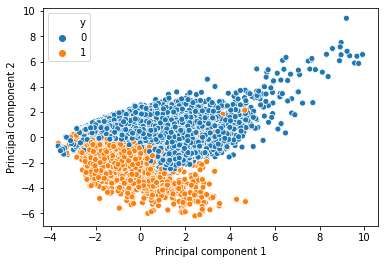

In [52]:
sns.scatterplot(data=df_pc, hue='y', x=0, y=1)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

<h1><center>Conclusion </center></h1>

In [53]:
print('The 10x cross validation F1 score for KNN is', knnf1 )
print('The 10x cross validation F1 score for LR is', lrf1 )
print('The 10x cross validation F1 score for ANN is', mlpf1 )
print('The 10x cross validation F1 score for SVM is', svcf1 )

The 10x cross validation F1 score for KNN is 0.9561064546600047
The 10x cross validation F1 score for LR is 0.9100394252708008
The 10x cross validation F1 score for ANN is 0.9515910637118792
The 10x cross validation F1 score for SVM is 0.9627562303504152
